In [26]:
import networkx as nx
import numpy as np
import random
from tqdm import tqdm
import sys
import seaborn as sns
import matplotlib.pyplot as plt 

from cassiopeia.TreeSolver.simulation_tools.simulation_utils import node_to_string, get_leaves_of_tree
from cassiopeia.TreeSolver.Node import Node
from cassiopeia.TreeSolver.Cassiopeia_Tree import Cassiopeia_Tree

from cassiopeia.TreeSolver.simulation_tools import dataset_generation as data_gen

from cassiopeia.TreeSolver import utilities as util
import pandas as pd 

sys.path.append("/data/yosef2/users/mattjones/projects/kptc/jungle/") # specify path to jungle
import jungle as jg

In [2]:
def compute_priors(C, S, p, mean=0.01, disp=0.1, empirical = np.array([])):
    
    sp = {}
    prior_probabilities = {}
    for i in range(0, C):
        if len(empirical) > 0:
            sampled_probabilities = sorted(empirical)
        else:
            sampled_probabilities = sorted([np.random.negative_binomial(mean,disp) for _ in range(1,S+1)])
        mut_rate = p
        prior_probabilities[i] = {'0': (1-mut_rate)}
        total = np.sum(sampled_probabilities)

        sampled_probabilities = list(map(lambda x: x / (1.0 * total), sampled_probabilities))
            
        for j in range(1, S+1):
            prior_probabilities[i][str(j)] = (mut_rate)*sampled_probabilities[j-1]

    return prior_probabilities, sp 


In [33]:
def phylo_forward_sim(
    mutation_prob_map,
    variable_dropout_prob_map,
    characters=10,
    dropout=True, # perform dropout on cells 
    min_alpha = 0.0, # minimum baseline mutation rate
    U = lambda: np.random.exponential(1, 1),
    depth = 11, # depth of tree, or number of time steps
    beta = 0, # extinction rate,
    mu = 0.05, # mutation rate 
):

    alpha = min_alpha+((1-min_alpha)*np.random.random()) # probability that cell will double per time-step (between 0.75 and 1.0)


    network = nx.DiGraph()
    current_depth = [Node('state-node', character_vec=["0" for _ in range(0, characters)])]
    
    network.add_node(current_depth[0])
    network.node[current_depth[0]]["fitness"] = 1.0
    uniq = 1

    for i in tqdm(range(0, depth), desc="Generating cells at each level in tree"):
        temp_current_depth = []
        
        fs = [network.nodes[n]['fitness'] for n in current_depth]
        norm = np.max(fs)
        
        for node in current_depth:
            
            fitness = network.node[node]['fitness']
            
            # cell death
            if np.random.random() < beta:
                
                anc = list(network.predecessors(node))[0]
                network.remove_node(node)
                while network.out_degree(anc) == 0:
                    node = anc
                    anc = list(network.predecessors(node))[0]
                    network.remove_node(node)
                
            else:
                if np.random.random() < alpha * (fitness / norm):
                    for _ in range(0, 2):

                        # simulate indel information for node
                        child_node = data_gen.simulate_mutation(node.char_vec, mutation_prob_map)
                        #child_node = []
                        if i == depth - 1:
                            child_node = data_gen.simulate_dropout(child_node, variable_dropout_prob_map)

                        child_node = Node('state-node', character_vec = child_node)

                        temp_current_depth.append(child_node)
                        network.add_edge(
                            node, child_node
                        )
                        
                        if i == depth - 1:
                            network.node[child_node]['fitness'] = fitness
                        else:
                            # adding a mutation with some selection coefficient
                            if np.random.random() < mu:

                                s = max(1e-20, U()[0])
                                _fitness = fitness * s
                                network.node[child_node]['fitness'] = _fitness

                            else: 
                                network.node[child_node]['fitness'] = fitness

                            uniq += 1
                else:

                    _new_charstring = data_gen.simulate_mutation(node.char_vec, mutation_prob_map)
                    if i == depth - 1:
                        _new_charstring = data_gen.simulate_dropout(_new_charstring, variable_dropout_prob_map)
                    # _new_charstring = []
                    node.char_string = "|".join(_new_charstring)
                    node.character_vec = _new_charstring 

                    temp_current_depth.append(node)
                
        current_depth = temp_current_depth

    # rename nodes for easy lookup later 
    i = 0
    for n in network.nodes:
        n.name = 'StateNode' + str(i)
        i += 1

    tree = Cassiopeia_Tree("simulated", network=network)
    return tree

def collapse_tree(tree, root):
    
    to_collapse = []
    for child in tree.successors(root):
        if not tree.out_degree(child) == 0:
            collapse_tree(tree, child)
            if child.char_string == root.char_string:
                to_collapse.append(child)
                
    for child in to_collapse:
        tree.add_edges_from([(root, sd) for sd in tree.successors(child)])
        tree.remove_node(child)
        

In [54]:
### no_mut_rate = 0.985
mut_rate = 0.01
number_of_states = 40
dropout = 0.17
depth = 8
number_of_characters = 40

pp, sp = compute_priors(number_of_characters, number_of_states, mut_rate, mean=1, disp=0.1)

In [61]:
N_clones = 100 #number of clones to simulate
mu = 0.01 # max mutation rate for fitness simulations
min_alpha = 0.2 # min rate of doubling
beta = 0.1 #extinction rate

In [62]:
tree = phylo_forward_sim(
    pp,
    [dropout] * number_of_characters,
    characters=number_of_characters,
    dropout=True, # perform dropout on cells 
    min_alpha = min_alpha, # minimum baseline mutation rate
    U = lambda: 1.0 + np.random.exponential(1, 1),
    depth = 100, # depth of tree, or number of time steps
    beta = beta, # extinction rate,
    mu = 0.01, # mutation rate
)

Generating cells at each level in tree: 100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


In [63]:
nw = util.convert_network_to_newick_format(tree.network)
with open('test_sim.nw', 'w') as f:
    f.write(nw)

_tree = tree.network.copy()
root = [n for n in _tree if _tree.in_degree(n) == 0][0]
collapse_tree(_tree, root)


redges = 0
for e in _tree.edges():
    if e[0].char_string == e[1].char_string:
        redges += 1
        
nw = util.convert_network_to_newick_format(_tree)
with open('test_sim.collapsed.nw', 'w') as f:
    f.write(nw)

1 trees
Size of trees:
1236 leaves
node_ranking: inferring ancestral fitness... 
done in 57.21s
node_ranking: calculating alternative rankings...
done in 2.32s


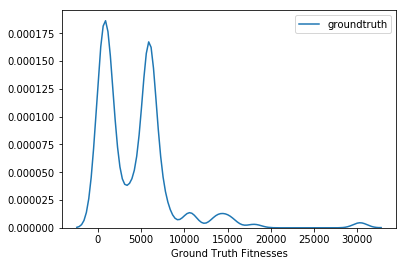

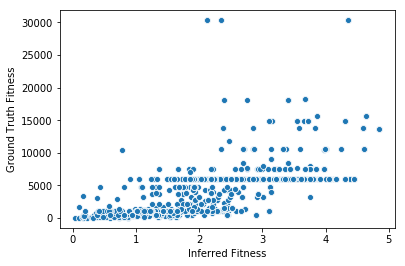

In [64]:
net = _tree

nw = util.convert_network_to_newick_format(net)

infiles = [nw]
F_empirical = jg.Forest.from_newick(infiles)

print(str(len(F_empirical)) + " trees")

print("Size of trees:")
for t in F_empirical.trees:
    print(str(len(t)) + " leaves")
    
names_trees = ["sim_net"]

F_empirical.annotate_standard_node_features()
F_empirical.infer_fitness(params={})

processed_tree = F_empirical.trees[0]
inf_fit = {}
for node in processed_tree.T.traverse():
    if node.is_leaf():
        inf_fit[node.name] = node.mean_fitness
        
leaves = [n for n in net if net.out_degree(n) == 0]
fs = dict(zip([n.name for n in net], [net.nodes[n]['fitness'] for n in net]))

sns.kdeplot([n for n in fs.values()], label = 'groundtruth')
plt.xlabel('Ground Truth Fitnesses')
plt.show()

sns.scatterplot([inf_fit[n.name] for n in leaves], [fs[n.name] for n in leaves])
plt.xlabel('Inferred Fitness')
plt.ylabel('Ground Truth Fitness')
plt.show()


In [52]:
with open('test_sim.nw', 'w') as f:
    f.write(nw)
    
test_sim_df = pd.DataFrame.from_dict(inf_fit, columns = ['Inferred'], orient='index')
test_sim_df['GroundTruth'] = test_sim_df.apply(lambda x: fs[x.name], axis=1)
test_sim_df['NormGroundTruth'] = test_sim_df.apply(lambda x: x.GroundTruth / np.max(test_sim_df['GroundTruth'].values), axis=1)
test_sim_df.to_csv('test_sim_fitnesses.txt', sep='\t')

In [53]:
test_sim_df.head(5)

,Inferred,GroundTruth,NormGroundTruth
StateNode83,0.634073,35.587014,0.000072
StateNode75,0.136646,35.587014,0.000072
StateNode186,0.856371,82.223875,0.000167
StateNode187,0.856371,82.223875,0.000167
StateNode85,0.029315,35.587014,0.000072
